In [1]:
%load_ext autoreload

In [2]:
%autoreload 2
from collections import defaultdict
from datetime import datetime
import h5py
from kneed import KneeLocator
import math
import matplotlib.pyplot as plt
from neural_analysis.matIO import loadmat
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, filtfilt, freqz
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

sys.path.append('../../..')
from multiproc import compute_VAR
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [19]:
session = 'Mary-Anesthesia-20160912-02'
# session = 'Mary-Anesthesia-20160809-01'

In [20]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [21]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [22]:
spike_times = spike_times[0]

# Concatenate Up and Down States

In [23]:
area_spike_dict = {}
for area in np.hstack([session_info['areas'], ['all']]):
    print(area)
    if area == 'all':
        unit_inds = np.arange(len(unit_info['area']))
    else:
        unit_inds = np.where(unit_info['area'] == area)[0]
    area_spike_dict[area] = np.zeros((len(unit_inds), T))
    for i, ind in enumerate(unit_inds):
        unit_spike_times = spike_times[ind][0, :]
        for t in unit_spike_times:
            area_spike_dict[area][i, int(t/dt)] = 1

vlPFC
FEF
CPB
7b
all


In [116]:
up_down_dict = get_up_down(area_spike_dict)

In [117]:
area = 'vlPFC'

In [118]:
anesthesia_up_down = up_down_dict[area][int(session_info['drugStart'][0]/dt):int(session_info['drugEnd'][1]/dt)]

In [119]:
anesthesia_lfp = lfp[int(session_info['drugStart'][0]/dt):int(session_info['drugEnd'][1]/dt), np.where(electrode_info['area'] == area)[0]]
up_lfp = anesthesia_lfp[np.where(anesthesia_up_down == 1)[0]]
down_lfp = anesthesia_lfp[np.where(anesthesia_up_down == 0)[0]]

In [120]:
anesthesia_spikes = area_spike_dict[area][:, int(session_info['drugStart'][0]/dt):int(session_info['drugEnd'][1]/dt)].T
up_spikes = anesthesia_spikes[np.where(anesthesia_up_down == 1)[0]]
down_spikes = anesthesia_spikes[np.where(anesthesia_up_down == 0)[0]]

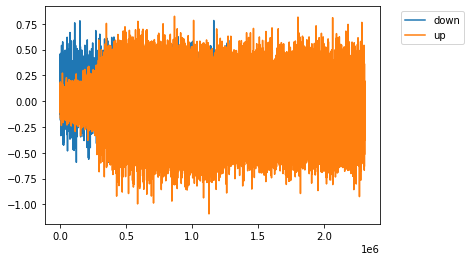

In [121]:
plt.plot(down_lfp[:, 0], label='down')
plt.plot(up_lfp[:, 0], label='up')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.show()

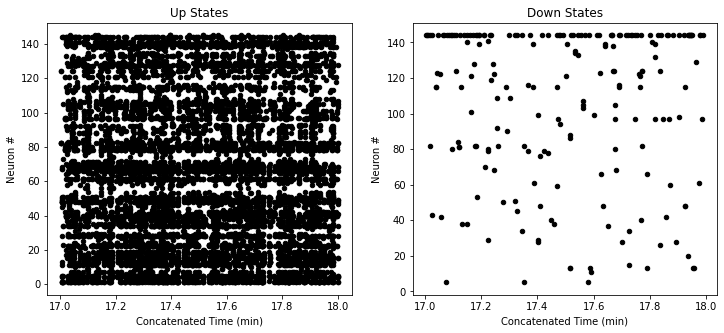

In [122]:
t_range = np.array([17, 18]) # minutes

t_range_inds = t_range*60*1000

up_spikes_plot = up_spikes.copy()
up_spikes_plot[up_spikes_plot == 0] = None
down_spikes_plot = down_spikes.copy()
down_spikes_plot[down_spikes_plot == 0] = None

fig, axs = plt.subplots(1, 2, figsize=(12, 5))

ax = axs[0]
for i in range(up_spikes_plot.shape[1]):
    ax.scatter(np.arange(len(up_spikes_plot))[t_range_inds[0]:t_range_inds[1]]/(1000*60), up_spikes_plot[:, i][t_range_inds[0]:t_range_inds[1]] + i, s = 20, c='k')
#     ax.scatter(np.arange(len(up_spikes_plot)), up_spikes_plot[:, i] + i, s = 20, c='k')
ax.set_title("Up States")
ax.set_ylabel("Neuron #")
ax.set_xlabel('Concatenated Time (min)')

ax = axs[1]
for i in range(down_spikes_plot.shape[1]):
    ax.scatter(np.arange(len(down_spikes_plot))[t_range_inds[0]:t_range_inds[1]]/(1000*60), down_spikes_plot[:, i][t_range_inds[0]:t_range_inds[1]] + i, s = 20, c='k')
#     ax.scatter(np.arange(len(down_spikes_plot)), down_spikes_plot[:, i] + i, s = 20, c='k')
ax.set_title("Down States")
ax.set_ylabel("Neuron #")
ax.set_xlabel('Concatenated Time (min)')
    
plt.show()

In [110]:
# VAR_results, window_selection_info = run_window_selection(session, return_data=True, verbose=False)

In [85]:
# plot_individual_areas(session, data_class, VAR_results, session_info)

In [36]:
# window = window_selection_info['selected_windows']['during'][area]

In [123]:
# CALCULATE UP STATES
up_results = []
stride = window
num_windows = int(np.floor((len(up_lfp) -int(window/dt))/int(stride/dt))+1)
for i in tqdm(range(num_windows)):
    window_data = up_lfp[i*int(stride/dt):i*int(stride/dt) + int(window/dt)]
    results = compute_VAR(window_data)
    
    results['start_time'] = i*stride
    results['start_step'] = i*int(stride/dt)
    results['end_time'] = i*stride + window
    results['end_step'] = i*int(stride/dt) + int(window/dt)
    
    up_results.append(results)

  0%|          | 0/307 [00:00<?, ?it/s]

In [124]:
# CALCULATE DOWN STATES
down_results = []
stride = window
num_windows = int(np.floor((len(down_lfp) -int(window/dt))/int(stride/dt))+1)
for i in tqdm(range(num_windows)):
    window_data = down_lfp[i*int(stride/dt):i*int(stride/dt) + int(window/dt)]
    results = compute_VAR(window_data)
    
    results['start_time'] = i*stride
    results['start_step'] = i*int(stride/dt)
    results['end_time'] = i*stride + window
    results['end_step'] = i*int(stride/dt) + int(window/dt)
    
    down_results.append(results)

  0%|          | 0/172 [00:00<?, ?it/s]

In [125]:
up_df = pd.DataFrame(up_results)
down_df = pd.DataFrame(down_results)

In [126]:
anesthesia_time_vals = session_info['drugStart'][0] + np.arange(int((session_info['drugEnd'][1] - session_info['drugStart'][0])/dt))
up_time = anesthesia_time_vals[np.where(anesthesia_up_down==1)]
down_time = anesthesia_time_vals[np.where(anesthesia_up_down==0)]

down_window_times = np.zeros(len(down_df))
for i, row in down_df.iterrows():
    down_window_times[i] = down_time[row.start_step:row.end_step].mean()
    
up_window_times = np.zeros(len(up_df))
for i, row in up_df.iterrows():
    up_window_times[i] = up_time[row.start_step:row.end_step].mean()

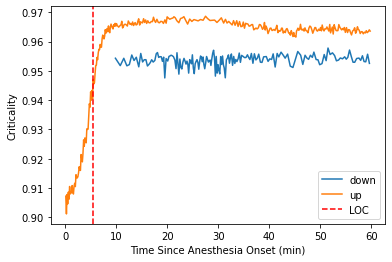

In [127]:
eyes_close = session_info['eyesClose'][1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

plt.plot(down_window_times/(1000*60), down_df.criticality_inds.apply(lambda x: x.mean()), label='down')
plt.plot(up_window_times/(1000*60), up_df.criticality_inds.apply(lambda x: x.mean()), label='up')
plt.xlabel('Time Since Anesthesia Onset (min)')
plt.axvline((eyes_close - session_info['drugStart'][0])/60, c='r', linestyle='--', label='LOC')
plt.ylabel('Criticality')
plt.legend()
plt.show()

# Spike Triggered Average

In [175]:
all_up_spikes = []
for unit_num in tqdm(range(up_spikes.shape[1])):
    all_up_spikes.extend(np.where(up_spikes[:, unit_num])[0])
all_up_spikes = np.unique(all_up_spikes)

all_down_spikes = []
for unit_num in tqdm(range(down_spikes.shape[1])):
    all_down_spikes.extend(np.where(down_spikes[:, unit_num])[0])
all_down_spikes = np.unique(all_down_spikes)

  0%|          | 0/145 [00:00<?, ?it/s]

  0%|          | 0/145 [00:00<?, ?it/s]

In [163]:
unit_num = 64

In [177]:
sta_length = 1 # s

# UP

up_sta_back = np.zeros((int(sta_length/dt), up_lfp.shape[1]))
back_count = 0
up_sta_middle = np.zeros((int(sta_length/dt), up_lfp.shape[1]))
middle_count = 0
up_sta_forward = np.zeros((int(sta_length/dt), up_lfp.shape[1]))
forward_count = 0
# for spike_ind in np.where(up_spikes[:, unit_num])[0]:
for spike_ind in tqdm(all_up_spikes):
    if spike_ind > int(sta_length/dt):
        up_sta_back += up_lfp[spike_ind - int(sta_length/dt):spike_ind]
        back_count += 1
    if spike_ind > int(sta_length/(2*dt)) and spike_ind < up_lfp.shape[0] - int(sta_length/(2*dt)):
        up_sta_middle += up_lfp[spike_ind - int(sta_length/(2*dt)):spike_ind + int(sta_length/(2*dt))]
        middle_count += 1
    if spike_ind < up_lfp.shape[0] - int(sta_length/dt):
        up_sta_forward += up_lfp[spike_ind:spike_ind + int(sta_length/dt)]
        forward_count += 1
    
up_sta_back /= back_count
up_sta_middle /= middle_count
up_sta_forward /= forward_count

# DOWN

down_sta_back = np.zeros((int(sta_length/dt), down_lfp.shape[1]))
back_count = 0
down_sta_middle = np.zeros((int(sta_length/dt), down_lfp.shape[1]))
middle_count = 0
down_sta_forward = np.zeros((int(sta_length/dt), down_lfp.shape[1]))
forward_count = 0
# for spike_ind in np.where(down_spikes[:, unit_num])[0]:
for spike_ind in tqdm(all_down_spikes):
    if spike_ind > int(sta_length/dt):
        down_sta_back += down_lfp[spike_ind - int(sta_length/dt):spike_ind]
        back_count += 1
    if spike_ind > int(sta_length/(2*dt)) and spike_ind < down_lfp.shape[0] - int(sta_length/(2*dt)):
        down_sta_middle += down_lfp[spike_ind - int(sta_length/(2*dt)):spike_ind + int(sta_length/(2*dt))]
        middle_count += 1
    if spike_ind < down_lfp.shape[0] - int(sta_length/dt):
        down_sta_forward += down_lfp[spike_ind:spike_ind + int(sta_length/dt)]
        forward_count += 1
    
down_sta_back /= back_count
down_sta_middle /= middle_count
down_sta_forward /= forward_count

  0%|          | 0/556789 [00:00<?, ?it/s]

  0%|          | 0/3708 [00:00<?, ?it/s]

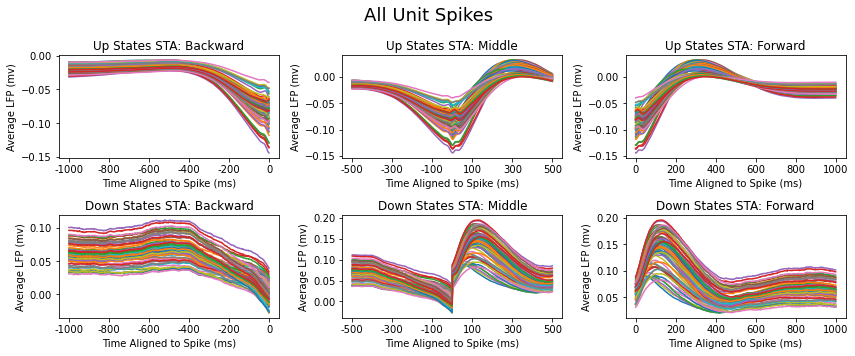

In [178]:
fig, axs = plt.subplots(2, 3, figsize=(12, 5))

# up back
ax = axs[0][0]
for i in range(up_sta_back.shape[1]):
    ax.plot(up_sta_back[:, i])
ax.set_title("Up States STA: Backward")
ax.set_xticks(np.linspace(0, int(sta_length/dt), 6))
ax.set_xticklabels([int(t) for t in np.linspace(-int(sta_length/dt), 0, 6)])
ax.set_xlabel("Time Aligned to Spike (ms)")
ax.set_ylabel("Average LFP (mv)")

# up middle
ax = axs[0][1]
for i in range(up_sta_middle.shape[1]):
    ax.plot(up_sta_middle[:, i])
ax.set_title("Up States STA: Middle")
ax.set_xticks(np.linspace(0, int(sta_length/dt), 6))
ax.set_xticklabels([int(t) for t in np.linspace(-int(sta_length/(2*dt)), int(sta_length/(2*dt)), 6)])
ax.set_xlabel("Time Aligned to Spike (ms)")
ax.set_ylabel("Average LFP (mv)")

# up forward
ax = axs[0][2]
for i in range(up_sta_forward.shape[1]):
    ax.plot(up_sta_forward[:, i])
ax.set_title("Up States STA: Forward")
ax.set_xticks(np.linspace(0, int(sta_length/dt), 6))
ax.set_xticklabels([int(t) for t in np.linspace(0, int(sta_length/dt), 6)])
ax.set_xlabel("Time Aligned to Spike (ms)")
ax.set_ylabel("Average LFP (mv)")

# down back
ax = axs[1][0]
for i in range(down_sta_back.shape[1]):
    ax.plot(down_sta_back[:, i])
ax.set_title("Down States STA: Backward")
ax.set_xticks(np.linspace(0, int(sta_length/dt), 6))
ax.set_xticklabels([int(t) for t in np.linspace(-int(sta_length/dt), 0, 6)])
ax.set_xlabel("Time Aligned to Spike (ms)")
ax.set_ylabel("Average LFP (mv)")

# down middle
ax = axs[1][1]
for i in range(down_sta_middle.shape[1]):
    ax.plot(down_sta_middle[:, i])
ax.set_title("Down States STA: Middle")
ax.set_xticks(np.linspace(0, int(sta_length/dt), 6))
ax.set_xticklabels([int(t) for t in np.linspace(-int(sta_length/(2*dt)), int(sta_length/(2*dt)), 6)])
ax.set_xlabel("Time Aligned to Spike (ms)")
ax.set_ylabel("Average LFP (mv)")

# down forward
ax = axs[1][2]
for i in range(down_sta_forward.shape[1]):
    ax.plot(down_sta_forward[:, i])
ax.set_title("Down States STA: Forward")
ax.set_xticks(np.linspace(0, int(sta_length/dt), 6))
ax.set_xticklabels([int(t) for t in np.linspace(0, int(sta_length/dt), 6)])
ax.set_xlabel("Time Aligned to Spike (ms)")
ax.set_ylabel("Average LFP (mv)")

# plt.suptitle(f'Unit {unit_num} Spikes', fontsize=18)
plt.suptitle(f'All Unit Spikes', fontsize=18)
plt.tight_layout()
plt.show()